In [75]:
import cirq
from cirq import LineQubit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import sympy

In [76]:
# 2.1 - Decomposing the Hamiltonian

H_given = np.array([[1, 0, 0, 0], 
                    [0, 0, -1, 0], 
                    [0, -1, 0, 0],
                    [0, 0, 0, 1]])

pauli_zz = cirq.unitary(cirq.ZZ)
pauli_xx = cirq.unitary(cirq.XX)
pauli_yy = cirq.unitary(cirq.YY)
eye4 = np.eye(4) # II

# Decomposed H_given = (ZZ + II - XX - YY)/2
H_decomp = np.array([pauli_zz, eye4, pauli_xx, pauli_yy])
H_weights = np.array([0.5, 0.5, -0.5, -0.5])
H_tot = np.zeros((4,4), dtype=complex)
for x in range(len(H_decomp)):
    H_tot += H_decomp[x] * H_weights[x]

# Show that the H_given = H_decomp
print(np.array_equal(H_given, H_tot))

True


In [70]:
# 2.2 - The Ansatz & Creating the VQE Circuit Layers

# Define each layer of the ansatz
# (RX I)
def RX_I_layer(qubits, theta):
    rot_x = cirq.rx(theta)
    for i in range(len(qubits)):
        if i == 0: yield rot_x(LineQubit(i))
        else: yield cirq.I(qubits[i])

# CX
def CX_layer(qubits, dir):
    if (dir == 0):
        yield cirq.CX(qubits[0], qubits[1])
    elif (dir == 1):
        yield cirq.CX(qubits[1], qubits[0])

# HI
def HI_layer(qubits):
    for i in range(len(qubits)):
        if i == 0: yield cirq.H(qubits[i])
        else: yield cirq.I(qubits[i])

# Define the total ansatz (RX I) CX (HI)
def ansatz_RXI_CX_HI(qubits, params):
    yield RX_I_layer(qubits, params[0])
    yield CX_layer(qubits, 0)
    yield HI_layer(qubits)

# Define correction subcircuts
def XX_correction(qubits):
    x_corr = cirq.ry(-np.pi/2)
    for i in range(len(qubits)):
        yield x_corr(qubits[i])

def YY_correction(qubits):
    y_corr = cirq.rx(np.pi/2)
    for i in range(len(qubits)):
        yield y_corr(qubits[i])



In [77]:
# 2.3 - Creating and Simulating the Circuits
num_qubits = 2
expectations = {'II': 0.5 * np.ones(10)}
qubits = LineQubit.range(num_qubits)

def get_expectation_zz(psi):
    # Calculates expectation with Z basis using <psi|ZZ|psi>
    psi = np.atleast_2d(psi)
    return np.linalg.multi_dot([psi.conjugate(), pauli_zz, psi.transpose()]).item()
    
# theta_vals = np.linspace(0, 2*np.pi, 100)
alpha = sympy.Symbol('alpha')
sweep = cirq.Linspace(key='alpha', start=0, stop=2*np.pi, length=10)
simulator = cirq.Simulator()

# Limitation: doesn't work if there are cross terms in the Hamiltonian (I.E. XY, YZ, ZI, etc)
def calc_expectations_all(qubits, ansatz, params):
    for term in H_decomp:
        # Don't need to calculate expectations for the II term
        if np.array_equal(term, eye4): continue
            
        ckt = cirq.Circuit()
        ckt.append(ansatz(qubits, params))
        # Add the corrections. None needed for ZZ
        if (np.array_equal(term, pauli_xx)):
            ckt.append(XX_correction(qubits))
            print("\nXX Term Circuit: ")
        elif (np.array_equal(term, pauli_yy)): 
            ckt.append(YY_correction(qubits))
            print("\nYY Term Circuit: ")
        else:
            print("\nZZ Term Circuit: ")
        print(ckt)
        trial_results = simulator.simulate_sweep(ckt, params=sweep)
        exptn_list = [get_expectation_zz(result.final_state) for result in trial_results]
        if (np.array_equal(term, pauli_xx)):
            expectations['XX'] = np.real(exptn_list) * -0.5
        elif (np.array_equal(term, pauli_yy)): 
            expectations['YY'] = np.real(exptn_list) * 0.5
        else: 
            expectations['ZZ'] = np.real(exptn_list) * 0.5
        # Need some explanation for taking the real part (probably because pauli observables are always real)

calc_expectations_all(qubits, ansatz_RXI_CX_HI, [alpha])



ZZ Term Circuit: 
0: ───Rx(alpha)───@───H───
                  │
1: ───I───────────X───I───

XX Term Circuit: 
0: ───Rx(alpha)───@───H───Ry(-0.5π)───
                  │
1: ───I───────────X───I───Ry(-0.5π)───

YY Term Circuit: 
0: ───Rx(alpha)───@───H───Rx(0.5π)───
                  │
1: ───I───────────X───I───Rx(0.5π)───


The upper bound for the lowest eigenvalue for the Hamilotnian is: 0.5
The actual lowest eigenvalue for the given Hamilotnian is: -1.0


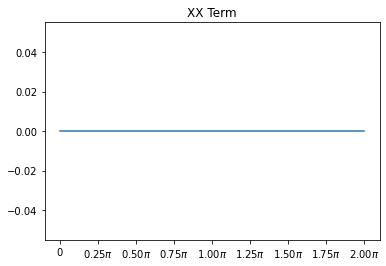

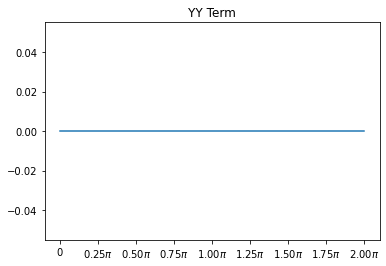

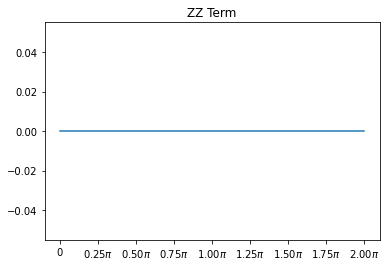

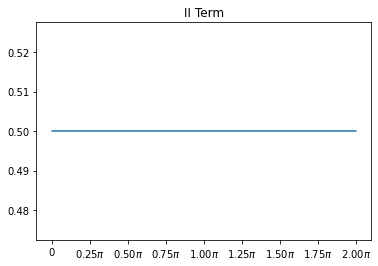

In [72]:
# 2.4 - Plotting and Finding the Lower Bound
theta_vals = np.linspace(0, 2*np.pi, 10)

# Thanks for the plotting code Michał (:
def plot_values(x, y, title=None):
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(tck.FuncFormatter(
           lambda val,pos: '{:.2f}$\pi$'.format(val/np.pi) if val !=0 else '0'
        ))
    ax.xaxis.set_major_locator(tck.MultipleLocator(base=np.pi/4))
    ax.plot(x, y)
    if title is not None:
        ax.set_title(title)

plot_values(theta_vals, expectations['XX'], "XX Term")
plot_values(theta_vals, expectations['YY'], "YY Term")
plot_values(theta_vals, expectations['ZZ'], "ZZ Term")
plot_values(theta_vals, expectations['II'], "II Term")

H_measured = sum(expectations.values())

print("The upper bound for the lowest eigenvalue for the Hamilotnian is: {}".format(np.amin(H_measured)))
print("The actual lowest eigenvalue for the given Hamilotnian is: {}".format(np.amin(np.linalg.eig(H_given)[0])))

In [73]:
# 3 - A New Ansatz

# Instead of HI at the end, lets do RY I
# Lets also do an RY for qubit 2 at the beginning

# (RY I)
def RY_I_layer(qubits, theta):
    rot_y = cirq.ry(theta)
    for i in range(len(qubits)):
        if i == 0: yield rot_y(LineQubit(i))
        else: yield cirq.I(qubits[i])
# (RX RY)
def RX_RY_layer(qubits, params):
    rot_x = cirq.rx(params[0])
    rot_y = cirq.ry(params[1])
    for i in range(len(qubits)):
        if i == 0: yield rot_x(LineQubit(i))
        else: yield rot_y(qubits[i])

# (RY RY)
def RY_RY_layer(qubits, params):
    rot_y_a = cirq.ry(params[0])
    rot_y_b = cirq.ry(params[1])
    for i in range(len(qubits)):
        if i == 0: yield rot_y_a(LineQubit(i))
        else: yield rot_y_b(qubits[i])

beta = sympy.Symbol('beta')
gamma = sympy.Symbol('gamma')
sweep = (cirq.Linspace(key='alpha', start=0, stop=2*np.pi, length=10)
         * cirq.Linspace(key='beta', start=0, stop=2*np.pi, length=10)
         * cirq.Linspace(key='gamma', start=0, stop=2*np.pi, length=10))
### Full Ansatzes ###

# (RX I) CX (RY I)
def ansatz_RXI_CX_RYI(qubits, params):
    yield RX_I_layer(qubits, params[0])
    yield CX_layer(qubits, 0)
    yield RY_I_layer(qubits, params[1])

# (RX RY) CX (RY I)
def ansatz_RXRY_CX_RYI(qubits, params):
    yield RX_RY_layer(qubits, params[0:2])
    yield CX_layer(qubits, 0)
    yield RY_I_layer(qubits, params[2])

# (RX RY) CX (RY I) 
def ansatz_RYRY_CX_RYI(qubits, params):
    yield RY_RY_layer(qubits, params[0:2])
    yield CX_layer(qubits, 0)
    yield RY_I_layer(qubits, params[2])


angles = [alpha, beta, gamma]
expectations = {'II': 0.5 * np.ones(1000)}

calc_expectations_all(qubits, ansatz_RXI_CX_RYI, angles)
print(np.amin(sum(expectations.values())))

calc_expectations_all(qubits, ansatz_RXRY_CX_RYI, angles)
print(np.amin(sum(expectations.values())))

calc_expectations_all(qubits, ansatz_RYRY_CX_RYI, angles)
print(np.amin(sum(expectations.values())))


ZZ Term Circuit: 
0: ───Rx(alpha)───@───Ry(beta)───
                  │
1: ───I───────────X───I──────────

XX Term Circuit: 
0: ───Rx(alpha)───@───Ry(beta)───Ry(-0.5π)───
                  │
1: ───I───────────X───I──────────Ry(-0.5π)───

YY Term Circuit: 
0: ───Rx(alpha)───@───Ry(beta)───Rx(0.5π)───
                  │
1: ───I───────────X───I──────────Rx(0.5π)───
0.03015366843805878

ZZ Term Circuit: 
0: ───Rx(alpha)───@───Ry(gamma)───
                  │
1: ───Ry(beta)────X───I───────────

XX Term Circuit: 
0: ───Rx(alpha)───@───Ry(gamma)───Ry(-0.5π)───
                  │
1: ───Ry(beta)────X───I───────────Ry(-0.5π)───

YY Term Circuit: 
0: ───Rx(alpha)───@───Ry(gamma)───Rx(0.5π)───
                  │
1: ───Ry(beta)────X───I───────────Rx(0.5π)───
0.03015366843805878

ZZ Term Circuit: 
0: ───Ry(alpha)───@───Ry(gamma)───
                  │
1: ───Ry(beta)────X───I───────────

XX Term Circuit: 
0: ───Ry(alpha)───@───Ry(gamma)───Ry(-0.5π)───
                  │
1: ───Ry(beta)────X───I──

In [74]:
# 3.1 - A 4th Parameter

delta = sympy.Symbol('delta')
sweep = (cirq.Linspace(key='alpha', start=0, stop=2*np.pi, length=10)
         * cirq.Linspace(key='beta', start=0, stop=2*np.pi, length=10)
         * cirq.Linspace(key='gamma', start=0, stop=2*np.pi, length=10)
         * cirq.Linspace(key='delta', start=0, stop=2*np.pi, length=10))
         
# (RX RX)
def RX_RX_layer(qubits, params):
    rot_x_a = cirq.rx(params[0])
    rot_x_b = cirq.rx(params[1])
    for i in range(len(qubits)):
        if i == 0: yield rot_x_a(LineQubit(i))
        else: yield rot_x_b(qubits[i])

# (RX RX) CX (RY RY) CX
def ansatz_RXRX_CX_RYRY_CX(qubits, params):
    yield RX_RX_layer(qubits, params[0:2])
    yield CX_layer(qubits, 0)
    yield RY_RY_layer(qubits, params[2:])
    yield CX_layer(qubits, 1)

angles = [alpha, beta, gamma, delta]
expectations = {'II': 0.5 * np.ones(10000)}
calc_expectations_all(qubits, ansatz_RXRX_CX_RYRY_CX, angles)

print(np.amin(sum(expectations.values())))



ZZ Term Circuit: 
0: ───Rx(alpha)───@───Ry(gamma)───X───
                  │               │
1: ───Rx(beta)────X───Ry(delta)───@───

XX Term Circuit: 
0: ───Rx(alpha)───@───Ry(gamma)───X───Ry(-0.5π)───
                  │               │
1: ───Rx(beta)────X───Ry(delta)───@───Ry(-0.5π)───

YY Term Circuit: 
0: ───Rx(alpha)───@───Ry(gamma)───X───Rx(0.5π)───
                  │               │
1: ───Rx(beta)────X───Ry(delta)───@───Rx(0.5π)───
0.0004580881253091196
